### Import trained model
Run `nvidia-smi -l 1` to check the memory being used by what.
You will need to restart the kernel if the program is crashing as jupyter stays allive and keeps the data in the memory.

In [1]:
import pickle
import keras
import librosa
import librosa.display
import numpy as np
from sklearn import metrics
import tensorflow as tf
from keras.models import load_model

#sound_model_file = "sound_model.pkl"
label_encoder_file = "labelencoder.pkl"


model = None

model = load_model('sound_category_model.h5')

#with open(sound_model_file, 'rb') as file:
#    model = pickle.load(file)

with open(label_encoder_file, 'rb') as file:
    le = pickle.load(file)

%store -r x_train 
%store -r x_test 
%store -r y_train 
%store -r y_test 
#%store -r model 
#%store -r le
%store -r X
%store -r y

Using TensorFlow backend.


In [2]:
usl = "../resources/UrbanSound8K/"

In [3]:

num_rows = 40
num_columns = 174
num_channels = 1

max_pad_len = 174

x_train = x_train.reshape(x_train.shape[0], num_rows, num_columns, num_channels)
x_test = x_test.reshape(x_test.shape[0], num_rows, num_columns, num_channels)

# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=1)
print("Training Accuracy: ", score[1])

score = model.evaluate(x_test, y_test, verbose=1)
print("Testing Accuracy: ", score[1])

7936/7936 [==============================] - 1s 143us/step
Training Accuracy:  0.991431474685669
1984/1984 [==============================] - 0s 57us/step
Testing Accuracy:  0.9284273982048035


In [4]:
def prediction(file_name, print_data = False):
    prediction_feature = extract_features(file_name) 
    prediction_feature = prediction_feature.reshape(1, num_rows, num_columns, num_channels)

    predicted_vector = model.predict_classes(prediction_feature)
    predicted_class = le.inverse_transform(predicted_vector)
    predicted_proba_vector = model.predict_proba(prediction_feature) 
    predicted_proba = predicted_proba_vector[0]
    if print_data:
        print("The predicted class is:", predicted_class[0], '\n') 
        
        for i in range(len(predicted_proba)): 
            category = le.inverse_transform(np.array([i]))
            print(category[0], "\t\t : ", format(predicted_proba[i], '.32f') )
    return (predicted_class[0], format(predicted_proba[predicted_vector[0]] * 100, '.32f'))

In [5]:
def extract_features(file_name):
   
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        pad_width = max_pad_len - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        
    except Exception as e:
        print("Error encountered while parsing file: ", file_name, e)
        return None 
     
    return mfccs

In [6]:
# Class: Air Conditioner

filename = usl + 'audio/fold5/100852-0-0-0.wav' 
prediction(filename, True) 

The predicted class is: air_conditioner 

air_conditioner 		 :  0.99993717670440673828125000000000
car_horn 		 :  0.00000000020732929262301524886425
children_playing 		 :  0.00000354806434188503772020339966
dog_bark 		 :  0.00004350428935140371322631835938
door_bell 		 :  0.00000000000000000000115511753770
drilling 		 :  0.00000170514215369621524587273598
engine_idling 		 :  0.00000029379316401900723576545715
fire_alarm 		 :  0.00000000000095748799514017157719
jackhammer 		 :  0.00000000003057138917017532264708
music 		 :  0.00000000000125251154933780917133
person_talking 		 :  0.00000000000000000025418197813655
shuffling 		 :  0.00000000000072244391458725631949
siren 		 :  0.00001334303760813781991600990295
street_music 		 :  0.00000039132260098995175212621689


('air_conditioner', '99.99371767044067382812500000000000')

In [7]:
predictions = model.predict(x_test)
y_pred = (predictions > 0.5)
matrix = metrics.confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

### Checking data from testing for more info

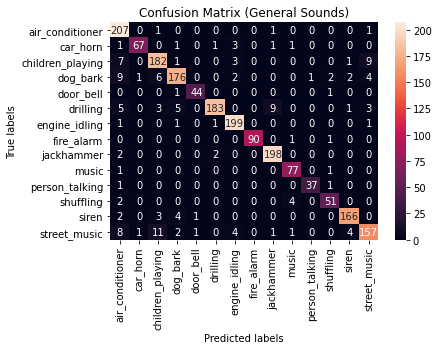

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

label_names = le.classes_

plt.figure()
ax= plt.subplot(111)
sns.heatmap(matrix, annot=True, ax = ax, fmt='g')

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix (General Sounds)')
ax.xaxis.set_ticklabels(label_names, rotation='vertical');
ax.yaxis.set_ticklabels(label_names, rotation='horizontal');

plt.savefig('confusion_matrix.png', bbox_inches='tight')

plt.show()

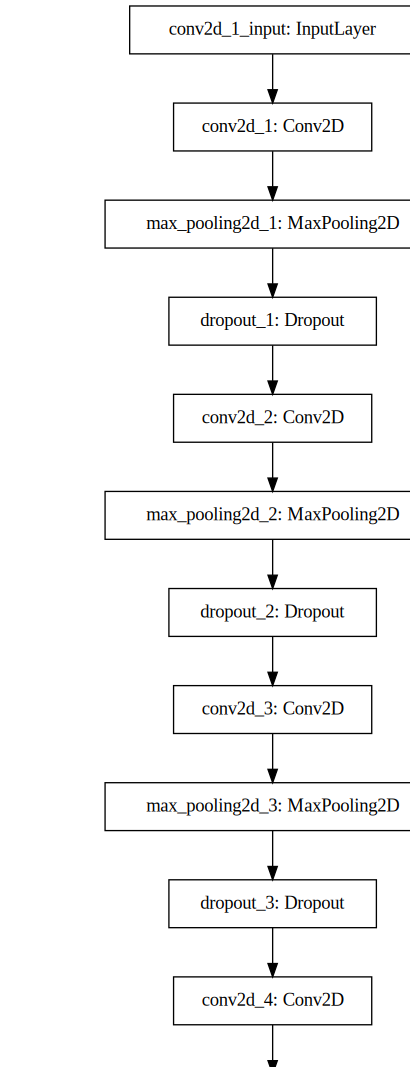

In [9]:
from IPython.display import SVG
from keras.utils import model_to_dot

# The output is a bit dodgy so you need to change the viewport value to
# width="550" height="1467" viewBox="0.00 0.00 550.00 1467.00"
with open("model_graph.svg", 'wb') as file:
    file.write(model_to_dot(model).create(prog='dot', format='svg'))
    
SVG("model_graph.svg")

### Test with sounds from odas

In [10]:
from os import listdir
from os.path import isfile, join

odas_clips = "/home/sekwah/Music/"

sound_files = [f for f in listdir(odas_clips) if isfile(join(odas_clips, f))]

#print(sound_files)

for file in sound_files:
    try:
        predict = prediction(join(odas_clips, file), False)
        print("{} {}% {}".format(predict[0], predict[1], file))
    except:
        print("Error reading file: " + join(odas_clips, file))

music 93.57081651687622070312500000000000% ODAS_77_2020-4-27_22-43-56-641_18_pf.wav
shuffling 99.92673993110656738281250000000000% ODAS_73_2020-4-26_18-48-6-926_2_pf.wav
shuffling 99.96075034141540527343750000000000% ODAS_1206_2020-4-27_23-16-49-581_2_pf.wav
person_talking 68.43648552894592285156250000000000% ODAS_79_2020-4-26_18-48-24-632_1_pf.wav
music 91.91401600837707519531250000000000% ODAS_30_2020-4-26_18-45-22-599_6_pf.wav
shuffling 87.16127872467041015625000000000000% ODAS_756_2020-4-28_14-29-16-343_9_pf.wav
person_talking 99.94992017745971679687500000000000% ODAS_2378_2020-4-28_14-47-18-986_15_pf.wav
person_talking 99.99951124191284179687500000000000% ODAS_332_2020-4-28_15-13-4-461_5_pf.wav
music 93.57081651687622070312500000000000% ODAS_77_2020-4-27_22-43-56-641_22_pf.wav
music 93.57081651687622070312500000000000% ODAS_36_2020-4-30_11-44-33-983_12_pf.wav
music 93.57081651687622070312500000000000% ODAS_145_2020-4-27_22-46-17-811_7_pf.wav
person_talking 81.399834156036376953125

Error encountered while parsing file:  /home/sekwah/Music/ODAS_2577_2020-4-28_14-55-3-533_sp.wav index can't contain negative values
Error reading file: /home/sekwah/Music/ODAS_2577_2020-4-28_14-55-3-533_sp.wav
shuffling 99.91753697395324707031250000000000% ODAS_537_2020-4-30_11-53-28-118_1_pf.wav
person_talking 99.48805570602416992187500000000000% ODAS_53_2020-4-30_11-45-7-341_10_pf.wav
person_talking 99.99375343322753906250000000000000% ODAS_673_2020-4-28_15-23-58-222_7_pf.wav
shuffling 33.07105600833892822265625000000000% ODAS_50_2020-5-3_21-12-32-76_pf.wav
person_talking 99.99809265136718750000000000000000% ODAS_96_2020-4-27_22-44-33-840_36_pf.wav
person_talking 99.99549388885498046875000000000000% ODAS_228_2020-4-27_22-51-2-22_2_pf.wav
music 89.63603377342224121093750000000000% ODAS_49_2020-5-3_21-12-29-301_3_pf.wav
children_playing 87.37015724182128906250000000000000% ODAS_218_2020-4-27_22-50-42-153_sp.wav
person_talking 99.99765157699584960937500000000000% ODAS_82_2020-4-26_18-4

person_talking 99.91524219512939453125000000000000% ODAS_2237_2020-4-28_14-44-57-881_9_pf.wav
shuffling 52.58864164352416992187500000000000% ODAS_650_2020-4-28_15-22-39-937_24_pf.wav
music 95.10064125061035156250000000000000% ODAS_30_2020-4-26_18-45-22-599_5_pf.wav
shuffling 99.89049434661865234375000000000000% ODAS_79_2020-4-26_18-48-24-632_2_pf.wav
person_talking 99.99926090240478515625000000000000% ODAS_2534_2020-4-28_14-52-59-625_32_pf.wav
person_talking 93.93622279167175292968750000000000% ODAS_60_2020-5-3_21-12-52-886_sp.wav
person_talking 99.99831914901733398437500000000000% ODAS_2298_2020-4-28_14-45-33-68_5_pf.wav
shuffling 99.94213581085205078125000000000000% ODAS_557_2020-4-30_11-54-56-631_1_pf.wav
person_talking 99.99243021011352539062500000000000% ODAS_2534_2020-4-28_14-52-59-625_41_pf.wav
music 93.57081651687622070312500000000000% ODAS_2175_2020-4-28_14-42-21-131_10_pf.wav
shuffling 52.98653244972229003906250000000000% ODAS_25_2020-4-26_18-45-20-20_6_pf.wav
shuffling 99.99

Error encountered while parsing file:  /home/sekwah/Music/ODAS_476_2020-4-30_11-51-41-842_sp.wav index can't contain negative values
Error reading file: /home/sekwah/Music/ODAS_476_2020-4-30_11-51-41-842_sp.wav
Error encountered while parsing file:  /home/sekwah/Music/ODAS_190_2020-4-28_15-10-14-368_sp.wav index can't contain negative values
Error reading file: /home/sekwah/Music/ODAS_190_2020-4-28_15-10-14-368_sp.wav
person_talking 99.60697889328002929687500000000000% ODAS_514_2020-4-30_11-52-46-309_6_pf.wav
Error encountered while parsing file:  /home/sekwah/Music/ODAS_2561_2020-4-28_14-54-48-22_sp.wav index can't contain negative values
Error reading file: /home/sekwah/Music/ODAS_2561_2020-4-28_14-54-48-22_sp.wav
person_talking 99.86152648925781250000000000000000% ODAS_10_2020-4-30_11-43-21-538_5_pf.wav
door_bell 77.84177064895629882812500000000000% ODAS_229_2020-4-28_14-12-36-232_99_pf.wav
person_talking 95.67649364471435546875000000000000% ODAS_2441_2020-4-28_14-50-0-159_12_pf.wav

person_talking 99.99961853027343750000000000000000% ODAS_2534_2020-4-28_14-52-59-625_13_pf.wav
person_talking 97.30581641197204589843750000000000% ODAS_50_2020-4-27_22-41-38-153_58_pf.wav
person_talking 99.99856948852539062500000000000000% ODAS_96_2020-4-27_22-44-33-840_20_pf.wav
person_talking 99.98968839645385742187500000000000% ODAS_10_2020-4-30_11-43-21-538_23_pf.wav
shuffling 74.22619462013244628906250000000000% ODAS_488_2020-4-30_11-51-53-842_1_pf.wav
music 99.98327493667602539062500000000000% ODAS_229_2020-4-28_14-12-36-232_83_pf.wav
music 98.44341874122619628906250000000000% ODAS_6_2020-4-28_14-1-43-62_43_pf.wav
shuffling 85.87420582771301269531250000000000% ODAS_1512_2020-4-28_14-34-44-666_2_pf.wav
music 93.57081651687622070312500000000000% ODAS_36_2020-4-30_11-44-33-983_6_pf.wav
person_talking 99.99998807907104492187500000000000% ODAS_567_2020-4-28_15-18-48-29_13_pf.wav
shuffling 99.79888200759887695312500000000000% ODAS_8_2020-5-3_21-11-15-668_2_pf.wav
person_talking 99.9994

music 93.57081651687622070312500000000000% ODAS_77_2020-4-27_22-43-56-641_11_pf.wav
shuffling 99.69135522842407226562500000000000% ODAS_651_2020-4-27_23-0-8-18_pf.wav
person_talking 99.99994039535522460937500000000000% ODAS_2138_2020-4-28_14-40-49-275_13_pf.wav
shuffling 98.47058653831481933593750000000000% ODAS_289_2020-4-28_15-11-6-381_4_pf.wav
person_talking 99.99989271163940429687500000000000% ODAS_50_2020-4-27_22-41-38-153_54_pf.wav
person_talking 99.99783039093017578125000000000000% ODAS_50_2020-4-27_22-41-38-153_131_pf.wav
Error encountered while parsing file:  /home/sekwah/Music/ODAS_145_2020-4-27_22-46-17-811_sp.wav index can't contain negative values
Error reading file: /home/sekwah/Music/ODAS_145_2020-4-27_22-46-17-811_sp.wav
shuffling 99.97381567955017089843750000000000% ODAS_50_2020-4-27_22-41-38-153_141_pf.wav
shuffling 90.69120287895202636718750000000000% ODAS_756_2020-4-28_14-29-16-343_11_pf.wav
car_horn 37.68944740295410156250000000000000% ODAS_598_2020-4-28_15-20-20-1

music 99.99420642852783203125000000000000% ODAS_242_2020-4-27_22-51-19-985_10_pf.wav
music 93.57081651687622070312500000000000% ODAS_145_2020-4-27_22-46-17-811_12_pf.wav
person_talking 99.99916553497314453125000000000000% ODAS_63_2020-5-3_21-12-53-519_8_pf.wav
music 93.57081651687622070312500000000000% ODAS_36_2020-4-30_11-44-33-983_11_pf.wav
music 96.52857184410095214843750000000000% ODAS_209_2020-4-28_14-11-41-822_35_pf.wav
person_talking 64.96322154998779296875000000000000% ODAS_539_2020-4-28_14-23-52-215_2_pf.wav
person_talking 99.99953508377075195312500000000000% ODAS_550_2020-4-28_15-18-3-627_16_pf.wav
person_talking 99.99899864196777343750000000000000% ODAS_2138_2020-4-28_14-40-49-275_6_pf.wav
music 100.00000000000000000000000000000000% ODAS_303_2020-4-27_22-52-34-910_15_pf.wav
person_talking 99.99663829803466796875000000000000% ODAS_409_2020-4-27_22-57-5-643_1_pf.wav
music 99.98881816864013671875000000000000% ODAS_523_2020-4-30_11-53-10-295_sp.wav
person_talking 98.808598518371

person_talking 75.86513161659240722656250000000000% ODAS_186_2020-4-27_22-48-6-986_7_pf.wav
music 93.57081651687622070312500000000000% ODAS_2547_2020-4-28_14-54-5-677_11_pf.wav
music 93.57081651687622070312500000000000% ODAS_2547_2020-4-28_14-54-5-677_7_pf.wav
shuffling 45.80839872360229492187500000000000% ODAS_40_2020-4-28_14-4-39-929_pf.wav
person_talking 99.84425902366638183593750000000000% ODAS_96_2020-4-27_22-44-33-840_3_pf.wav
door_bell 51.21688842773437500000000000000000% ODAS_8_2020-5-3_21-11-15-668_15_pf.wav
shuffling 99.97743964195251464843750000000000% ODAS_229_2020-4-28_14-12-36-232_111_pf.wav
shuffling 99.13355708122253417968750000000000% ODAS_10_2020-4-30_11-43-21-538_45_pf.wav
person_talking 99.95272159576416015625000000000000% ODAS_82_2020-4-26_18-48-35-999_3_pf.wav
person_talking 99.97933506965637207031250000000000% ODAS_50_2020-4-27_22-41-38-153_23_pf.wav
person_talking 99.93863105773925781250000000000000% ODAS_96_2020-4-27_22-44-33-840_17_pf.wav
person_talking 79.564

person_talking 72.45510220527648925781250000000000% ODAS_29_2020-5-3_21-11-33-106_12_pf.wav
shuffling 99.28885102272033691406250000000000% ODAS_1512_2020-4-28_14-34-44-666_5_pf.wav
person_talking 99.91136193275451660156250000000000% ODAS_2557_2020-4-28_14-54-22-735_14_pf.wav
person_talking 99.97090697288513183593750000000000% ODAS_2489_2020-4-28_14-52-6-40_5_pf.wav
dog_bark 93.15369129180908203125000000000000% ODAS_567_2020-4-28_15-18-48-29_pf.wav
person_talking 99.59646463394165039062500000000000% ODAS_2512_2020-4-28_14-52-47-405_7_pf.wav
person_talking 99.97745156288146972656250000000000% ODAS_65_2020-4-28_14-5-47-434_5_pf.wav
person_talking 99.99343156814575195312500000000000% ODAS_161_2020-4-27_22-46-50-827_29_pf.wav
Error encountered while parsing file:  /home/sekwah/Music/ODAS_497_2020-4-30_11-52-9-673_sp.wav index can't contain negative values
Error reading file: /home/sekwah/Music/ODAS_497_2020-4-30_11-52-9-673_sp.wav
music 93.57081651687622070312500000000000% ODAS_522_2020-4-3

dog_bark 97.33778238296508789062500000000000% ODAS_514_2020-4-30_11-52-46-309_14_pf.wav
person_talking 92.99999475479125976562500000000000% ODAS_2454_2020-4-28_14-50-42-676_8_pf.wav
door_bell 73.50784540176391601562500000000000% ODAS_242_2020-4-27_22-51-19-985_2_pf.wav
shuffling 88.64782452583312988281250000000000% ODAS_2138_2020-4-28_14-40-49-275_38_pf.wav
person_talking 99.72018003463745117187500000000000% ODAS_50_2020-4-27_22-41-38-153_134_pf.wav
person_talking 99.99794960021972656250000000000000% ODAS_161_2020-4-27_22-46-50-827_25_pf.wav
shuffling 99.44949746131896972656250000000000% ODAS_129_2020-4-27_22-45-50-128_21_pf.wav
door_bell 92.46751070022583007812500000000000% ODAS_2547_2020-4-28_14-54-5-677_1_pf.wav
person_talking 74.92092251777648925781250000000000% ODAS_515_2020-4-30_11-52-50-558_9_pf.wav
person_talking 99.98990297317504882812500000000000% ODAS_567_2020-4-28_15-18-48-29_26_pf.wav
person_talking 99.99889135360717773437500000000000% ODAS_2441_2020-4-28_14-50-0-159_29_pf

dog_bark 67.06541776657104492187500000000000% ODAS_58_2020-4-30_11-45-20-298_12_pf.wav
door_bell 88.54508399963378906250000000000000% ODAS_209_2020-4-28_14-11-41-822_26_pf.wav
shuffling 99.92123842239379882812500000000000% ODAS_686_2020-4-28_15-25-41-0_24_pf.wav
music 94.70390081405639648437500000000000% ODAS_209_2020-4-28_14-11-41-822_6_pf.wav
Error encountered while parsing file:  /home/sekwah/Music/ODAS_219_2020-4-27_22-50-43-400_sp.wav index can't contain negative values
Error reading file: /home/sekwah/Music/ODAS_219_2020-4-27_22-50-43-400_sp.wav
person_talking 99.99953508377075195312500000000000% ODAS_2378_2020-4-28_14-47-18-986_13_pf.wav
person_talking 99.99382495880126953125000000000000% ODAS_2577_2020-4-28_14-55-3-533_2_pf.wav
music 99.99682903289794921875000000000000% ODAS_30_2020-4-26_18-45-22-599_97_pf.wav
person_talking 87.25407719612121582031250000000000% ODAS_2298_2020-4-28_14-45-33-68_25_pf.wav
person_talking 94.35446262359619140625000000000000% ODAS_2378_2020-4-28_14-4

music 51.54983401298522949218750000000000% ODAS_232_2020-4-27_22-51-10-590_9_pf.wav
fire_alarm 99.92941617965698242187500000000000% ODAS_2542_2020-4-28_14-53-51-572_6_pf.wav
person_talking 69.07327771186828613281250000000000% ODAS_2298_2020-4-28_14-45-33-68_pf.wav
person_talking 99.99989271163940429687500000000000% ODAS_10_2020-4-30_11-43-21-538_39_pf.wav
shuffling 99.96693134307861328125000000000000% ODAS_719_2020-4-28_16-21-31-197_2_pf.wav
person_talking 99.99970197677612304687500000000000% ODAS_2441_2020-4-28_14-50-0-159_11_pf.wav
shuffling 69.05459761619567871093750000000000% ODAS_2570_2020-4-28_14-54-56-0_pf.wav
person_talking 73.17743897438049316406250000000000% ODAS_241_2020-4-27_22-51-18-51_pf.wav
shuffling 49.03198778629302978515625000000000% ODAS_79_2020-4-26_18-48-24-632_sp.wav
person_talking 99.96640682220458984375000000000000% ODAS_409_2020-4-28_15-15-23-748_3_pf.wav
dog_bark 91.19844436645507812500000000000000% ODAS_243_2020-4-27_22-51-20-113_pf.wav
person_talking 99.8022

music 85.00362038612365722656250000000000% ODAS_229_2020-4-28_14-12-36-232_13_pf.wav
person_talking 99.99855756759643554687500000000000% ODAS_100_2020-4-28_14-6-40-967_3_pf.wav
music 100.00000000000000000000000000000000% ODAS_303_2020-4-27_22-52-34-910_7_pf.wav
music 93.57081651687622070312500000000000% ODAS_2547_2020-4-28_14-54-5-677_10_pf.wav
person_talking 99.56976175308227539062500000000000% ODAS_96_2020-4-27_22-44-33-840_37_pf.wav
Error encountered while parsing file:  /home/sekwah/Music/ODAS_2557_2020-4-28_14-54-22-735_sp.wav index can't contain negative values
Error reading file: /home/sekwah/Music/ODAS_2557_2020-4-28_14-54-22-735_sp.wav
person_talking 80.05293011665344238281250000000000% ODAS_2454_2020-4-28_14-50-42-676_55_pf.wav
shuffling 98.77795577049255371093750000000000% ODAS_66_2020-4-26_18-47-47-268_2_pf.wav
shuffling 67.17504262924194335937500000000000% ODAS_811_2020-4-27_23-5-9-459_10_pf.wav
person_talking 99.99891519546508789062500000000000% ODAS_2298_2020-4-28_14-45-

Error encountered while parsing file:  /home/sekwah/Music/ODAS_2489_2020-4-28_14-52-6-40_sp.wav index can't contain negative values
Error reading file: /home/sekwah/Music/ODAS_2489_2020-4-28_14-52-6-40_sp.wav
fire_alarm 100.00000000000000000000000000000000% ODAS_2534_2020-4-28_14-52-59-625_50_pf.wav
person_talking 96.12850546836853027343750000000000% ODAS_53_2020-4-30_11-45-7-341_2_pf.wav
shuffling 99.94229078292846679687500000000000% ODAS_23_2020-4-30_11-44-13-687_1_pf.wav
person_talking 99.99502897262573242187500000000000% ODAS_289_2020-4-28_15-11-6-381_8_pf.wav
shuffling 84.15441513061523437500000000000000% ODAS_161_2020-4-27_22-46-50-827_32_pf.wav
Error encountered while parsing file:  /home/sekwah/Music/ODAS_592_2020-4-30_11-56-0-901_sp.wav index can't contain negative values
Error reading file: /home/sekwah/Music/ODAS_592_2020-4-30_11-56-0-901_sp.wav
person_talking 86.98059916496276855468750000000000% ODAS_229_2020-4-28_14-12-36-232_30_pf.wav
shuffling 99.399524927139282226562500

person_talking 99.99823570251464843750000000000000% ODAS_2378_2020-4-28_14-47-18-986_36_pf.wav
person_talking 99.99942779541015625000000000000000% ODAS_10_2020-4-30_11-43-21-538_28_pf.wav
person_talking 99.99513626098632812500000000000000% ODAS_2489_2020-4-28_14-52-6-40_9_pf.wav
music 62.63919472694396972656250000000000% ODAS_241_2020-4-27_22-51-18-51_2_pf.wav
person_talking 99.99104738235473632812500000000000% ODAS_2138_2020-4-28_14-40-49-275_26_pf.wav
person_talking 96.41989469528198242187500000000000% ODAS_756_2020-4-28_14-29-16-343_18_pf.wav
shuffling 99.94530081748962402343750000000000% ODAS_51_2020-4-26_18-47-29-950_8_pf.wav
Error encountered while parsing file:  /home/sekwah/Music/ODAS_139_2020-4-28_14-7-31-844_sp.wav index can't contain negative values
Error reading file: /home/sekwah/Music/ODAS_139_2020-4-28_14-7-31-844_sp.wav
dog_bark 46.51869833469390869140625000000000% ODAS_229_2020-4-28_14-12-36-232_100_pf.wav
person_talking 68.01410317420959472656250000000000% ODAS_513_20

shuffling 99.99713897705078125000000000000000% ODAS_717_2020-4-28_16-21-28-788_2_pf.wav
music 93.57081651687622070312500000000000% ODAS_77_2020-4-27_22-43-56-641_20_pf.wav
shuffling 99.23930168151855468750000000000000% ODAS_1283_2020-4-28_14-33-36-84_2_pf.wav
dog_bark 42.60245859622955322265625000000000% ODAS_130_2020-4-28_15-8-18-528_sp.wav
shuffling 99.79552030563354492187500000000000% ODAS_795_2020-4-27_23-3-58-108_1_pf.wav
door_bell 61.40660643577575683593750000000000% ODAS_651_2020-4-27_23-0-8-18_1_pf.wav
fire_alarm 99.99921321868896484375000000000000% ODAS_2541_2020-4-28_14-53-51-198_sp.wav
shuffling 97.96360731124877929687500000000000% ODAS_699_2020-4-28_14-28-34-265_pf.wav
children_playing 98.36312532424926757812500000000000% ODAS_539_2020-4-27_22-58-45-478_sp.wav
music 39.71798717975616455078125000000000% ODAS_209_2020-4-28_14-11-41-822_pf.wav
music 99.32639598846435546875000000000000% ODAS_229_2020-4-28_14-12-36-232_16_pf.wav
music 93.57081651687622070312500000000000% ODAS_77

Error encountered while parsing file:  /home/sekwah/Music/ODAS_10_2020-4-30_11-43-21-538_sp.wav index can't contain negative values
Error reading file: /home/sekwah/Music/ODAS_10_2020-4-30_11-43-21-538_sp.wav
car_horn 80.41425347328186035156250000000000% ODAS_209_2020-4-28_14-11-41-822_9_pf.wav
person_talking 85.96910238265991210937500000000000% ODAS_2441_2020-4-28_14-50-0-159_16_pf.wav
person_talking 99.99982118606567382812500000000000% ODAS_567_2020-4-28_15-18-48-29_10_pf.wav
person_talking 62.62469291687011718750000000000000% ODAS_53_2020-5-3_21-12-43-406_7_pf.wav
music 93.57081651687622070312500000000000% ODAS_40_2020-4-28_14-4-39-929_4_pf.wav
music 99.99997615814208984375000000000000% ODAS_303_2020-4-27_22-52-34-910_24_pf.wav
person_talking 99.99276399612426757812500000000000% ODAS_2378_2020-4-28_14-47-18-986_50_pf.wav
dog_bark 40.55162072181701660156250000000000% ODAS_96_2020-4-27_22-44-33-840_51_pf.wav
person_talking 99.99998807907104492187500000000000% ODAS_550_2020-4-28_15-18-

Error encountered while parsing file:  /home/sekwah/Music/ODAS_303_2020-4-27_22-52-34-910_sp.wav index can't contain negative values
Error reading file: /home/sekwah/Music/ODAS_303_2020-4-27_22-52-34-910_sp.wav
music 86.88247203826904296875000000000000% ODAS_169_2020-4-28_14-8-32-885_pf.wav
children_playing 100.00000000000000000000000000000000% ODAS_57_2020-4-26_18-47-32-732_sp.wav
person_talking 84.35530662536621093750000000000000% ODAS_2559_2020-4-28_14-54-39-729_11_pf.wav
shuffling 74.24431443214416503906250000000000% ODAS_54_2020-5-3_21-12-49-110_sp.wav
music 99.71918463706970214843750000000000% ODAS_30_2020-4-26_18-45-22-599_48_pf.wav
person_talking 99.99996423721313476562500000000000% ODAS_547_2020-4-30_11-53-48-533_11_pf.wav
shuffling 65.43764472007751464843750000000000% ODAS_1630_2020-4-28_14-36-8-458_8_pf.wav
person_talking 97.80604243278503417968750000000000% ODAS_219_2020-4-27_22-50-43-400_5_pf.wav
person_talking 99.98919963836669921875000000000000% ODAS_96_2020-4-27_22-44-3

person_talking 96.96677327156066894531250000000000% ODAS_332_2020-4-28_15-13-4-461_23_pf.wav
person_talking 99.99941587448120117187500000000000% ODAS_50_2020-4-27_22-41-38-153_128_pf.wav
shuffling 90.41199088096618652343750000000000% ODAS_811_2020-4-27_23-5-9-459_pf.wav
person_talking 62.05840706825256347656250000000000% ODAS_10_2020-4-30_11-43-21-538_33_pf.wav
person_talking 99.99835491180419921875000000000000% ODAS_2577_2020-4-28_14-55-3-533_17_pf.wav
shuffling 98.93397688865661621093750000000000% ODAS_2402_2020-4-28_14-48-40-640_4_pf.wav
shuffling 99.86667633056640625000000000000000% ODAS_161_2020-4-27_22-46-50-827_pf.wav
person_talking 32.96275138854980468750000000000000% ODAS_229_2020-4-28_14-12-36-232_93_pf.wav
person_talking 99.86153841018676757812500000000000% ODAS_101_2020-4-27_22-44-43-571_3_pf.wav
music 98.92103672027587890625000000000000% ODAS_30_2020-4-26_18-45-22-599_2_pf.wav
music 89.53719139099121093750000000000000% ODAS_36_2020-4-30_11-44-33-983_pf.wav
person_talking 9

music 99.97981190681457519531250000000000% ODAS_229_2020-4-28_14-12-36-232_80_pf.wav
person_talking 72.57993221282958984375000000000000% ODAS_229_2020-4-28_14-12-36-232_4_pf.wav
music 99.99725818634033203125000000000000% ODAS_6_2020-4-28_14-1-43-62_87_pf.wav
person_talking 94.86109018325805664062500000000000% ODAS_706_2020-4-28_16-10-13-881_1_pf.wav
shuffling 98.32337498664855957031250000000000% ODAS_2454_2020-4-28_14-50-42-676_42_pf.wav
person_talking 99.94086027145385742187500000000000% ODAS_110_2020-4-28_14-6-57-564_3_pf.wav
shuffling 78.58913540840148925781250000000000% ODAS_133_2020-4-26_18-49-5-504_6_pf.wav
music 87.42918372154235839843750000000000% ODAS_30_2020-4-26_18-45-22-599_109_pf.wav
dog_bark 99.99312162399291992187500000000000% ODAS_516_2020-4-30_11-52-58-776_sp.wav
Error encountered while parsing file:  /home/sekwah/Music/ODAS_80_2020-4-27_22-43-57-382_sp.wav index can't contain negative values
Error reading file: /home/sekwah/Music/ODAS_80_2020-4-27_22-43-57-382_sp.wav


person_talking 91.49197340011596679687500000000000% ODAS_54_2020-5-3_21-12-49-110_pf.wav
children_playing 99.33887720108032226562500000000000% ODAS_499_2020-4-30_11-52-23-144_sp.wav
person_talking 99.82125759124755859375000000000000% ODAS_2534_2020-4-28_14-52-59-625_43_pf.wav
music 77.05026268959045410156250000000000% ODAS_516_2020-4-30_11-52-58-776_1_pf.wav
person_talking 85.35601496696472167968750000000000% ODAS_650_2020-4-28_15-22-39-937_7_pf.wav
person_talking 99.99959468841552734375000000000000% ODAS_68_2020-4-28_15-5-4-364_10_pf.wav
person_talking 98.91547560691833496093750000000000% ODAS_585_2020-4-30_11-55-38-135_4_pf.wav
person_talking 99.81334805488586425781250000000000% ODAS_29_2020-5-3_21-11-33-106_17_pf.wav
music 99.98254179954528808593750000000000% ODAS_229_2020-4-28_14-12-36-232_46_pf.wav
music 93.57081651687622070312500000000000% ODAS_418_2020-4-28_15-15-47-799_8_pf.wav
person_talking 99.93765950202941894531250000000000% ODAS_622_2020-4-28_15-21-3-399_6_pf.wav
person_ta

music 91.14125967025756835937500000000000% ODAS_229_2020-4-28_14-12-36-232_9_pf.wav
person_talking 94.45180892944335937500000000000000% ODAS_65_2020-4-28_14-5-47-434_12_pf.wav
person_talking 57.40754008293151855468750000000000% ODAS_50_2020-4-27_22-41-38-153_102_pf.wav
person_talking 99.87378716468811035156250000000000% ODAS_2298_2020-4-28_14-45-33-68_27_pf.wav
person_talking 99.87911581993103027343750000000000% ODAS_644_2020-4-28_15-22-11-417_8_pf.wav
shuffling 99.99938011169433593750000000000000% ODAS_37_2020-5-3_21-12-15-477_1_pf.wav
person_talking 63.28022480010986328125000000000000% ODAS_1567_2020-4-28_14-35-4-577_5_pf.wav
music 99.99960660934448242187500000000000% ODAS_229_2020-4-28_14-12-36-232_88_pf.wav
person_talking 44.63007450103759765625000000000000% ODAS_2378_2020-4-28_14-47-18-986_56_pf.wav
person_talking 92.94538497924804687500000000000000% ODAS_185_2020-4-28_14-9-42-312_pf.wav
person_talking 99.75103139877319335937500000000000% ODAS_673_2020-4-28_15-23-58-222_12_pf.wav


Error encountered while parsing file:  /home/sekwah/Music/ODAS_513_2020-4-30_11-52-45-480_sp.wav index can't contain negative values
Error reading file: /home/sekwah/Music/ODAS_513_2020-4-30_11-52-45-480_sp.wav
music 99.39629435539245605468750000000000% ODAS_30_2020-4-26_18-45-22-599_80_pf.wav
music 99.99494552612304687500000000000000% ODAS_229_2020-4-28_14-12-36-232_59_pf.wav
person_talking 99.96917247772216796875000000000000% ODAS_2534_2020-4-28_14-52-59-625_8_pf.wav
Error encountered while parsing file:  /home/sekwah/Music/ODAS_96_2020-4-27_22-44-33-840_sp.wav index can't contain negative values
Error reading file: /home/sekwah/Music/ODAS_96_2020-4-27_22-44-33-840_sp.wav
fire_alarm 99.47487711906433105468750000000000% ODAS_2540_2020-4-28_14-53-47-153_pf.wav
shuffling 95.96632122993469238281250000000000% ODAS_484_2020-4-30_11-51-51-280_pf.wav
Error encountered while parsing file:  /home/sekwah/Music/ODAS_673_2020-4-28_15-23-58-222_sp.wav index can't contain negative values
Error read

music 71.15883231163024902343750000000000% ODAS_30_2020-4-26_18-45-22-599_41_pf.wav
person_talking 75.41393041610717773437500000000000% ODAS_756_2020-4-28_14-29-16-343_2_pf.wav
shuffling 97.07121253013610839843750000000000% ODAS_32_2020-4-28_14-4-13-630_7_pf.wav
siren 78.96379828453063964843750000000000% ODAS_242_2020-4-27_22-51-19-985_5_pf.wav
music 35.88771224021911621093750000000000% ODAS_229_2020-4-28_14-12-36-232_3_pf.wav
fire_alarm 97.84854054450988769531250000000000% ODAS_2561_2020-4-28_14-54-48-23_5_pf.wav
person_talking 99.99939203262329101562500000000000% ODAS_2378_2020-4-28_14-47-18-986_26_pf.wav
children_playing 99.46877956390380859375000000000000% ODAS_624_2020-4-27_22-59-59-606_sp.wav
person_talking 99.99243021011352539062500000000000% ODAS_547_2020-4-30_11-53-48-533_26_pf.wav
music 98.59811067581176757812500000000000% ODAS_6_2020-4-28_14-1-43-62_42_pf.wav
shuffling 77.86283493041992187500000000000000% ODAS_733_2020-4-28_16-21-53-627_pf.wav
music 99.9998807907104492187500

shuffling 56.35316371917724609375000000000000% ODAS_50_2020-4-27_22-41-38-153_123_pf.wav
fire_alarm 100.00000000000000000000000000000000% ODAS_2544_2020-4-28_14-53-56-592_8_pf.wav
door_bell 68.97169351577758789062500000000000% ODAS_6_2020-4-28_14-1-43-62_38_pf.wav
shuffling 78.35366725921630859375000000000000% ODAS_8_2020-5-3_21-11-15-668_9_pf.wav
person_talking 99.99911785125732421875000000000000% ODAS_2534_2020-4-28_14-52-59-625_33_pf.wav
person_talking 96.55801653861999511718750000000000% ODAS_550_2020-4-28_15-18-3-627_21_pf.wav
person_talking 99.99989271163940429687500000000000% ODAS_673_2020-4-28_15-23-58-222_5_pf.wav
music 99.99997615814208984375000000000000% ODAS_2469_2020-4-28_14-51-40-433_8_pf.wav
person_talking 98.81889820098876953125000000000000% ODAS_75_2020-4-28_14-6-18-848_pf.wav
person_talking 99.98877048492431640625000000000000% ODAS_75_2020-4-28_14-6-18-848_1_pf.wav
shuffling 99.74209070205688476562500000000000% ODAS_76_2020-4-26_18-48-9-791_pf.wav
music 93.57081651687

Error encountered while parsing file:  /home/sekwah/Music/ODAS_1512_2020-4-28_14-34-44-666_sp.wav index can't contain negative values
Error reading file: /home/sekwah/Music/ODAS_1512_2020-4-28_14-34-44-666_sp.wav
music 99.99343156814575195312500000000000% ODAS_30_2020-4-26_18-45-22-599_116_pf.wav
person_talking 66.38017296791076660156250000000000% ODAS_96_2020-4-27_22-44-33-840_49_pf.wav
music 93.57081651687622070312500000000000% ODAS_145_2020-4-27_22-46-17-811_25_pf.wav
music 99.93016719818115234375000000000000% ODAS_30_2020-4-26_18-45-22-599_22_pf.wav
Error encountered while parsing file:  /home/sekwah/Music/ODAS_2378_2020-4-28_14-47-18-986_sp.wav index can't contain negative values
Error reading file: /home/sekwah/Music/ODAS_2378_2020-4-28_14-47-18-986_sp.wav
music 89.35590386390686035156250000000000% ODAS_6_2020-4-28_14-1-43-62_41_pf.wav
shuffling 99.99467134475708007812500000000000% ODAS_79_2020-4-26_18-48-24-632_3_pf.wav
person_talking 99.99889135360717773437500000000000% ODAS_45

Error encountered while parsing file:  /home/sekwah/Music/ODAS_2175_2020-4-28_14-42-21-131_sp.wav index can't contain negative values
Error reading file: /home/sekwah/Music/ODAS_2175_2020-4-28_14-42-21-131_sp.wav
music 93.57081651687622070312500000000000% ODAS_25_2020-4-28_14-3-57-729_1_pf.wav
fire_alarm 99.99871253967285156250000000000000% ODAS_2544_2020-4-28_14-53-56-592_9_pf.wav
person_talking 99.94118213653564453125000000000000% ODAS_686_2020-4-28_15-25-41-0_21_pf.wav
person_talking 99.99802112579345703125000000000000% ODAS_567_2020-4-28_15-18-48-29_11_pf.wav
person_talking 99.99996423721313476562500000000000% ODAS_10_2020-4-30_11-43-21-538_31_pf.wav
person_talking 99.99957084655761718750000000000000% ODAS_161_2020-4-27_22-46-50-827_20_pf.wav
music 99.65102076530456542968750000000000% ODAS_30_2020-4-26_18-45-22-599_58_pf.wav
music 93.57081651687622070312500000000000% ODAS_190_2020-4-28_15-10-14-368_6_pf.wav
person_talking 99.99836683273315429687500000000000% ODAS_50_2020-4-27_22-41

person_talking 97.15121388435363769531250000000000% ODAS_82_2020-4-27_22-44-0-100_1_pf.wav
person_talking 99.99088048934936523437500000000000% ODAS_550_2020-4-28_15-18-3-627_14_pf.wav
person_talking 99.98947381973266601562500000000000% ODAS_50_2020-4-27_22-41-38-153_8_pf.wav
person_talking 99.98996257781982421875000000000000% ODAS_680_2020-4-28_15-24-47-520_1_pf.wav
person_talking 99.86845850944519042968750000000000% ODAS_161_2020-4-27_22-46-50-827_31_pf.wav
person_talking 99.99998807907104492187500000000000% ODAS_50_2020-4-27_22-41-38-153_66_pf.wav
person_talking 98.90644550323486328125000000000000% ODAS_2559_2020-4-28_14-54-39-729_7_pf.wav
person_talking 95.30192613601684570312500000000000% ODAS_2298_2020-4-28_14-45-33-68_13_pf.wav
person_talking 98.61950874328613281250000000000000% ODAS_2454_2020-4-28_14-50-42-676_46_pf.wav
children_playing 99.99238252639770507812500000000000% ODAS_245_2020-4-27_22-51-24-400_sp.wav
person_talking 95.16718983650207519531250000000000% ODAS_2454_2020-4

shuffling 61.94264888763427734375000000000000% ODAS_550_2020-4-28_15-18-3-627_10_pf.wav
person_talking 96.37938141822814941406250000000000% ODAS_623_2020-4-28_15-21-16-1_6_pf.wav
music 99.99811649322509765625000000000000% ODAS_101_2020-4-28_14-6-48-305_4_pf.wav
person_talking 99.96691942214965820312500000000000% ODAS_50_2020-4-27_22-41-38-153_1_pf.wav
shuffling 99.55189228057861328125000000000000% ODAS_129_2020-4-26_18-49-0-564_2_pf.wav
children_playing 99.99629259109497070312500000000000% ODAS_66_2020-4-26_18-47-47-268_sp.wav
music 99.70904588699340820312500000000000% ODAS_242_2020-4-27_22-51-19-985_12_pf.wav
music 93.57081651687622070312500000000000% ODAS_24_2020-4-27_22-41-9-475_17_pf.wav
person_talking 99.40636754035949707031250000000000% ODAS_680_2020-4-28_15-24-47-520_2_pf.wav
shuffling 58.48229527473449707031250000000000% ODAS_756_2020-4-28_14-29-16-343_12_pf.wav
person_talking 99.99988079071044921875000000000000% ODAS_623_2020-4-28_15-21-16-1_3_pf.wav
person_talking 99.99768733

shuffling 94.46831941604614257812500000000000% ODAS_1160_2020-4-28_14-33-1-968_4_pf.wav
person_talking 99.99946355819702148437500000000000% ODAS_644_2020-4-28_15-22-11-417_6_pf.wav
person_talking 86.17357611656188964843750000000000% ODAS_50_2020-4-27_22-41-38-153_55_pf.wav
music 95.99702358245849609375000000000000% ODAS_30_2020-4-26_18-45-22-599_62_pf.wav
Error encountered while parsing file:  /home/sekwah/Music/ODAS_2402_2020-4-28_14-48-40-640_sp.wav index can't contain negative values
Error reading file: /home/sekwah/Music/ODAS_2402_2020-4-28_14-48-40-640_sp.wav
dog_bark 80.31120300292968750000000000000000% ODAS_245_2020-4-27_22-51-24-400_3_pf.wav
person_talking 99.99548196792602539062500000000000% ODAS_547_2020-4-30_11-53-48-533_35_pf.wav
person_talking 99.99953508377075195312500000000000% ODAS_289_2020-4-28_15-11-6-381_11_pf.wav
music 62.33666539192199707031250000000000% ODAS_36_2020-4-30_11-44-33-983_17_pf.wav
Error encountered while parsing file:  /home/sekwah/Music/ODAS_701_2020

music 56.49709105491638183593750000000000% ODAS_6_2020-4-28_14-1-43-62_18_pf.wav
person_talking 99.99936819076538085937500000000000% ODAS_547_2020-4-30_11-53-48-533_5_pf.wav
person_talking 99.99511241912841796875000000000000% ODAS_289_2020-4-28_15-11-6-381_35_pf.wav
person_talking 99.96131062507629394531250000000000% ODAS_2378_2020-4-28_14-47-18-986_18_pf.wav
Error encountered while parsing file:  /home/sekwah/Music/ODAS_316_2020-4-27_22-53-22-385_sp.wav index can't contain negative values
Error reading file: /home/sekwah/Music/ODAS_316_2020-4-27_22-53-22-385_sp.wav
music 98.42109680175781250000000000000000% ODAS_209_2020-4-28_14-11-41-822_32_pf.wav
music 99.99974966049194335937500000000000% ODAS_229_2020-4-28_14-12-36-232_90_pf.wav
person_talking 99.99855756759643554687500000000000% ODAS_547_2020-4-30_11-53-48-533_36_pf.wav
person_talking 43.48238706588745117187500000000000% ODAS_289_2020-4-28_15-11-6-381_2_pf.wav
fire_alarm 99.99998807907104492187500000000000% ODAS_2512_2020-4-28_14-

person_talking 99.64662790298461914062500000000000% ODAS_2489_2020-4-28_14-52-6-40_25_pf.wav
music 76.17049217224121093750000000000000% ODAS_587_2020-4-28_15-19-42-994_8_pf.wav
person_talking 74.67996478080749511718750000000000% ODAS_2542_2020-4-28_14-53-51-572_4_pf.wav
person_talking 99.99927282333374023437500000000000% ODAS_50_2020-4-27_22-41-38-153_5_pf.wav
music 99.99986886978149414062500000000000% ODAS_229_2020-4-28_14-12-36-232_41_pf.wav
person_talking 99.87807869911193847656250000000000% ODAS_29_2020-5-3_21-11-33-106_6_pf.wav
shuffling 99.91527795791625976562500000000000% ODAS_1512_2020-4-28_14-34-44-666_6_pf.wav
person_talking 99.99804496765136718750000000000000% ODAS_673_2020-4-28_15-23-58-222_14_pf.wav
person_talking 99.88273978233337402343750000000000% ODAS_680_2020-4-28_15-24-47-520_4_pf.wav
person_talking 100.00000000000000000000000000000000% ODAS_29_2020-5-3_21-11-33-106_38_pf.wav
person_talking 77.19180583953857421875000000000000% ODAS_515_2020-4-30_11-52-50-558_4_pf.wav

person_talking 99.65136647224426269531250000000000% ODAS_129_2020-4-27_22-45-50-128_13_pf.wav
fire_alarm 99.99998807907104492187500000000000% ODAS_2542_2020-4-28_14-53-51-572_2_pf.wav
music 99.42224621772766113281250000000000% ODAS_30_2020-4-26_18-45-22-599_71_pf.wav
music 99.98816251754760742187500000000000% ODAS_30_2020-4-26_18-45-22-599_87_pf.wav
person_talking 99.99564886093139648437500000000000% ODAS_2441_2020-4-28_14-50-0-159_37_pf.wav
music 99.93363022804260253906250000000000% ODAS_6_2020-4-28_14-1-43-62_47_pf.wav
music 93.57081651687622070312500000000000% ODAS_24_2020-4-27_22-41-9-475_15_pf.wav
music 94.65734958648681640625000000000000% ODAS_229_2020-4-28_14-12-36-232_33_pf.wav
shuffling 99.99873638153076171875000000000000% ODAS_498_2020-4-30_11-52-13-248_10_pf.wav
fire_alarm 75.75087547302246093750000000000000% ODAS_2489_2020-4-28_14-52-6-40_37_pf.wav
person_talking 49.43065047264099121093750000000000% ODAS_1630_2020-4-28_14-36-8-458_4_pf.wav
music 99.3647277355194091796875000

music 97.69897460937500000000000000000000% ODAS_229_2020-4-28_14-12-36-232_36_pf.wav
shuffling 65.86552858352661132812500000000000% ODAS_376_2020-4-28_14-20-48-946_1_pf.wav
person_talking 99.99637603759765625000000000000000% ODAS_289_2020-4-28_15-11-6-381_18_pf.wav
person_talking 51.29010677337646484375000000000000% ODAS_100_2020-4-28_14-6-40-967_pf.wav
person_talking 83.26998353004455566406250000000000% ODAS_514_2020-4-30_11-52-46-309_18_pf.wav
music 97.94623255729675292968750000000000% ODAS_30_2020-4-26_18-45-22-599_30_pf.wav
person_talking 99.81778860092163085937500000000000% ODAS_53_2020-5-3_21-12-43-406_6_pf.wav
music 99.89967942237854003906250000000000% ODAS_6_2020-4-28_14-1-43-62_90_pf.wav
door_bell 55.71057200431823730468750000000000% ODAS_209_2020-4-28_14-11-41-822_2_pf.wav
person_talking 99.20387268066406250000000000000000% ODAS_2557_2020-4-28_14-54-22-735_22_pf.wav
music 93.57081651687622070312500000000000% ODAS_769_2020-4-28_14-30-9-78_2_pf.wav
shuffling 99.6074855327606201